In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [15]:
from natsort import natsorted
from os import listdir
from scipy import sparse
from tqdm import tqdm
import math
import random
import numpy as np
import gc
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy 

In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, act = True):
        super(MLP, self).__init__()
        self.act_flag = act
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(self.in_dim, self.out_dim)
        self.act = nn.ReLU()
        
    def forward(self, pre_layer):
        x = self.linear(pre_layer)
        if self.act_flag:
            x = self.act(x)
        return x

In [4]:
class scAE(nn.Module):
    def __init__(self, encoder_nhiddens, decoder_nhiddens, act = True, device = "cuda:0"):
        super(scAE, self).__init__()
        
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        self.en_l = len(encoder_nhiddens)
        self.de_l = len(decoder_nhiddens)
        self.act = act
        
        for i in range(self.en_l-2):
            self.encoder.add_module("encoder_layer" + str(i), 
                                    MLP(encoder_nhiddens[i], encoder_nhiddens[i+1], self.act))
            
        self.encoder.add_module("encoder_layer" + str(self.en_l-1), 
                                MLP(encoder_nhiddens[self.en_l-2], encoder_nhiddens[self.en_l-1], act=False))
        
        for i in range(self.de_l-2):
            self.decoder.add_module("decoder_layer" + str(i),
                                    MLP(decoder_nhiddens[i], decoder_nhiddens[i+1], self.act))
            
        self.decoder.add_module("decoder_layer" + str(self.de_l-1), 
                                MLP(decoder_nhiddens[self.de_l-2], decoder_nhiddens[self.de_l-1], act=True))
            
    def forward(self, x):        
        for i in range(self.en_l-1):
            x = self.encoder[i](x)
            
        for i in range(self.en_l-1):
            x = self.decoder[i](x)
            
        return x

In [5]:
store_path = "scDDPM_model.pt"
best_model = scAE((17430, 2048, 1024, 512, 256), (256, 512, 1024, 2048, 17430)).to("cuda:0")
best_model.load_state_dict(torch.load(store_path))

<All keys matched successfully>

In [6]:
simu_data = torch.load('generated_cells.pt')

In [7]:
simu_data

tensor([[[-0.0840,  0.1611,  0.0764,  ...,  0.0699, -0.0513, -0.0074]],

        [[-0.0836,  0.0974,  0.7069,  ...,  0.0961, -0.0857, -0.1039]],

        [[ 0.0764, -0.3941, -0.0039,  ...,  0.0363, -0.0889,  0.0281]],

        ...,

        [[-0.0577, -0.0641, -0.3579,  ...,  0.0449, -0.0345,  0.0779]],

        [[-0.1337, -0.0230,  0.2789,  ...,  0.0503, -0.1973,  0.1031]],

        [[-0.0212,  0.1740,  0.9115,  ...,  0.2071, -0.1400,  0.0136]]],
       device='cuda:0')

In [9]:
recons = best_model.decoder(simu_data)

In [10]:
recons.shape

torch.Size([5000, 1, 17430])

In [27]:
recons = recons.squeeze()

In [28]:
recons.shape

torch.Size([5000, 17430])

In [16]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data_path = '/Shang_PHD/TrainingData/V1/HumanCellAtlas/'
        self.data = []
        for npz in natsorted(listdir(self.data_path)):
            self.data.append(self.data_path + npz)
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, sample):
        cell = np.load(self.data[sample])
        row = cell['row']
        col = cell['col']
        dat = cell['data']
        #coo = sparse.coo_matrix((dat, (row, col)), shape=(1, self.data['shape'][1]))
        idx = torch.tensor(np.array([row, col]))
        value = torch.tensor(dat, dtype=torch.float32)
        data_tensor = torch.sparse_coo_tensor(idx, value, (1, 17430))
        data_tensor = data_tensor.to_dense()
        data_tensor = data_tensor.squeeze()
        return data_tensor

In [17]:
dataset = CustomDataset()

In [23]:
random_selected, _ = torch.utils.data.random_split(dataset, [20000, 599926-20000])
val_loader = DataLoader(random_selected, batch_size=20000, shuffle=False)
val_data = next(iter(val_loader))

In [29]:
real_and_recon = np.concatenate((recons.cpu().detach().numpy(), val_data), 0)

In [31]:
real_and_recon.shape

(25000, 17430)

In [32]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(real_and_recon)

/home/sgao30/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


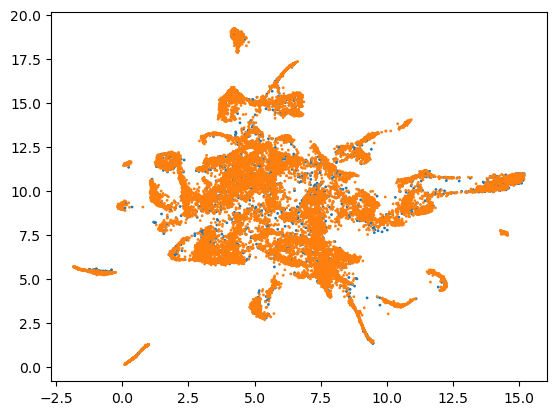

In [34]:
import matplotlib.pyplot as plt
import matplotlib
cellType = np.array(["Recons", "Real"])
newMetaData =  np.repeat(cellType, [5000, 20000], axis=0)
levels, categories = pd.factorize(newMetaData)
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, c=colors)

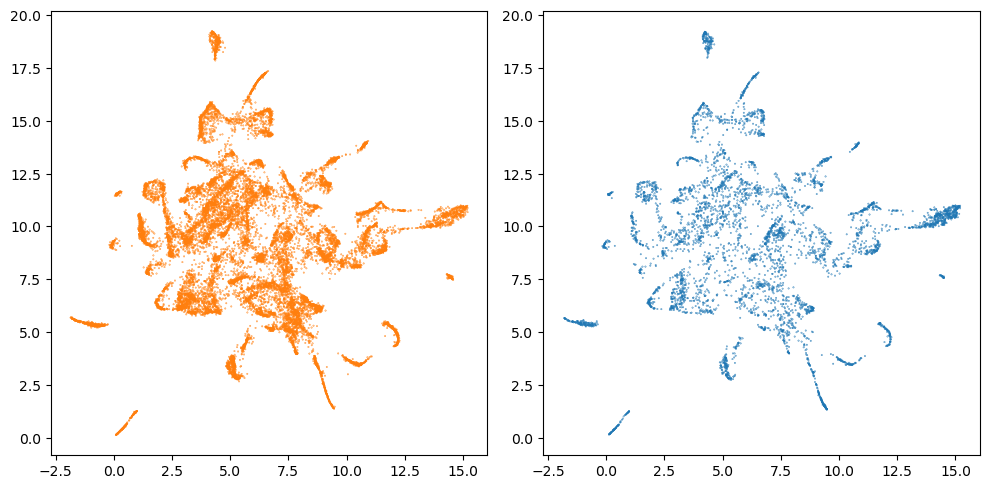

In [36]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1, 2, 1)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, c=colors, alpha=np.repeat(np.array([0, 1]), [5000, 20000], axis=0))
fig.add_subplot(1, 2, 2)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, c=colors, alpha=np.repeat(np.array([1, 0]), [5000, 20000], axis=0))
fig.tight_layout()